In [25]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import tifffile
from skimage.transform import resize
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
import dcgan as dcgan
import wgan as wgan
import prgan as prgan
from scores import scores
from scores import preprocess_array

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam



In [26]:
NOISE_DIM = 100  
BATCH_SIZE = 20 
STEPS_PER_EPOCH = 100
EPOCHS = 50
STEPS = 5
SEED = 40
WIDTH, HEIGHT, CHANNELS = 75, 75, 2
OPTIMIZER = Adam(0.0002, 0.5)

In [27]:
train = pd.read_json('./data/train.json')
train['inc_angle'] = pd.to_numeric(train['inc_angle'],errors='coerce')

In [28]:
def get_stats(train,label=1):
    train['max'+str(label)] = [np.max(np.array(x)) for x in train['band_'+str(label)] ]
    train['maxpos'+str(label)] = [np.argmax(np.array(x)) for x in train['band_'+str(label)] ]
    train['min'+str(label)] = [np.min(np.array(x)) for x in train['band_'+str(label)] ]
    train['minpos'+str(label)] = [np.argmin(np.array(x)) for x in train['band_'+str(label)] ]
    train['med'+str(label)] = [np.median(np.array(x)) for x in train['band_'+str(label)] ]
    train['std'+str(label)] = [np.std(np.array(x)) for x in train['band_'+str(label)] ]
    train['mean'+str(label)] = [np.mean(np.array(x)) for x in train['band_'+str(label)] ]
    train['p25_'+str(label)] = [np.sort(np.array(x))[int(0.25*75*75)] for x in train['band_'+str(label)] ]
    train['p75_'+str(label)] = [np.sort(np.array(x))[int(0.75*75*75)] for x in train['band_'+str(label)] ]
    train['mid50_'+str(label)] = train['p75_'+str(label)]-train['p25_'+str(label)]

    return train
train = get_stats(train,1)
train = get_stats(train,2)

In [29]:
def plot_var(name,nbins=50):
    minval = train[name].min()
    maxval = train[name].max()
    plt.hist(train.loc[train.is_iceberg==1,name],range=[minval,maxval],
             bins=nbins,color='b',alpha=0.5,label='Boat')
    plt.hist(train.loc[train.is_iceberg==0,name],range=[minval,maxval],
             bins=nbins,color='r',alpha=0.5,label='Iceberg')
    plt.legend()
    plt.xlim([minval,maxval])
    plt.xlabel(name)
    plt.ylabel('Number')
    plt.show()

753


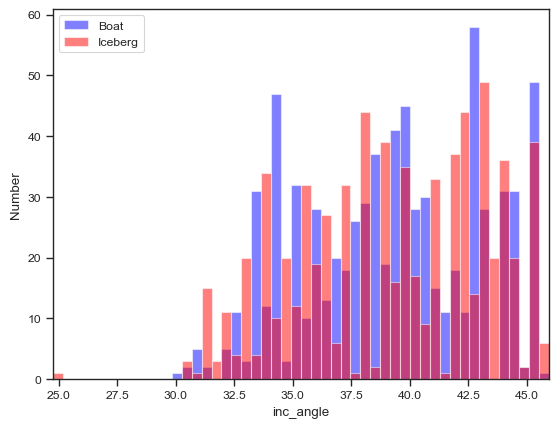

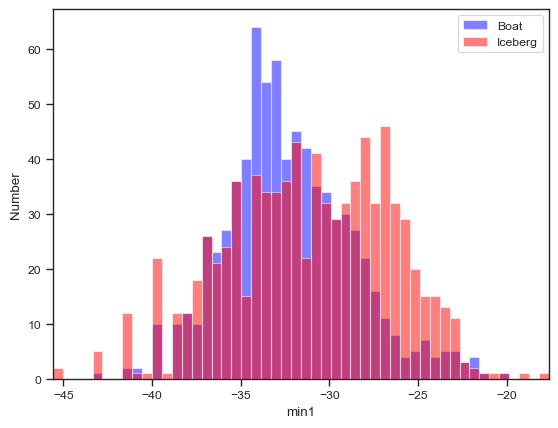

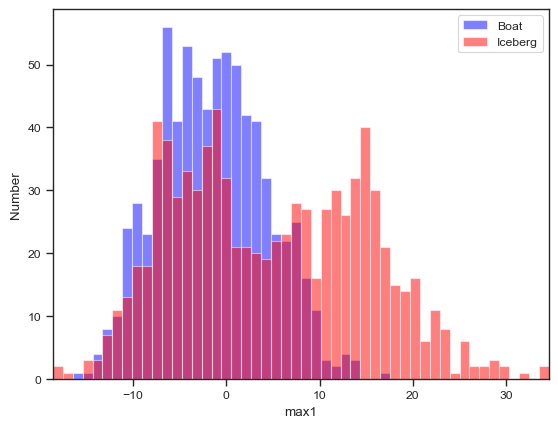

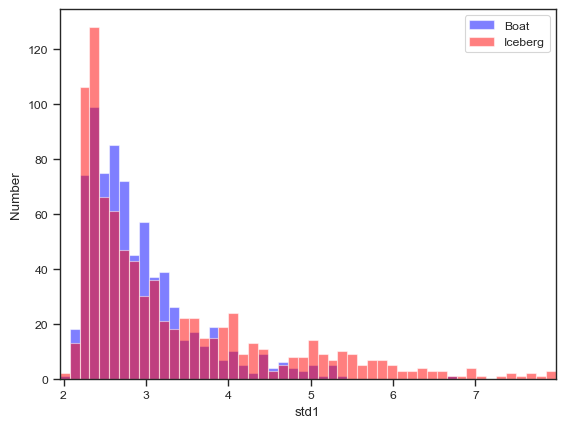

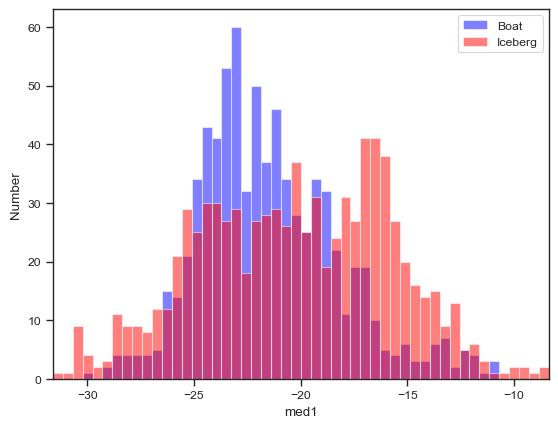

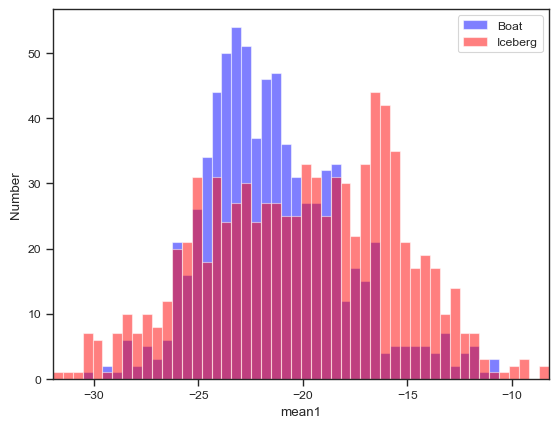

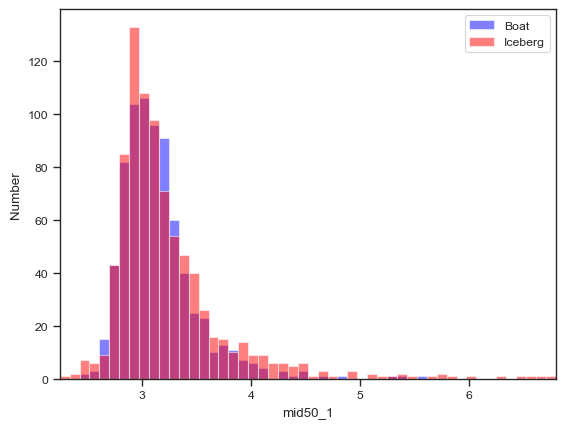

In [30]:
print(len(train.loc[train.is_iceberg==1]))
for col in ['inc_angle','min1','max1','std1','med1','mean1','mid50_1']:
    plot_var(col)

In [31]:
train_stats = train.drop(['id','is_iceberg','band_1','band_2'],axis=1)

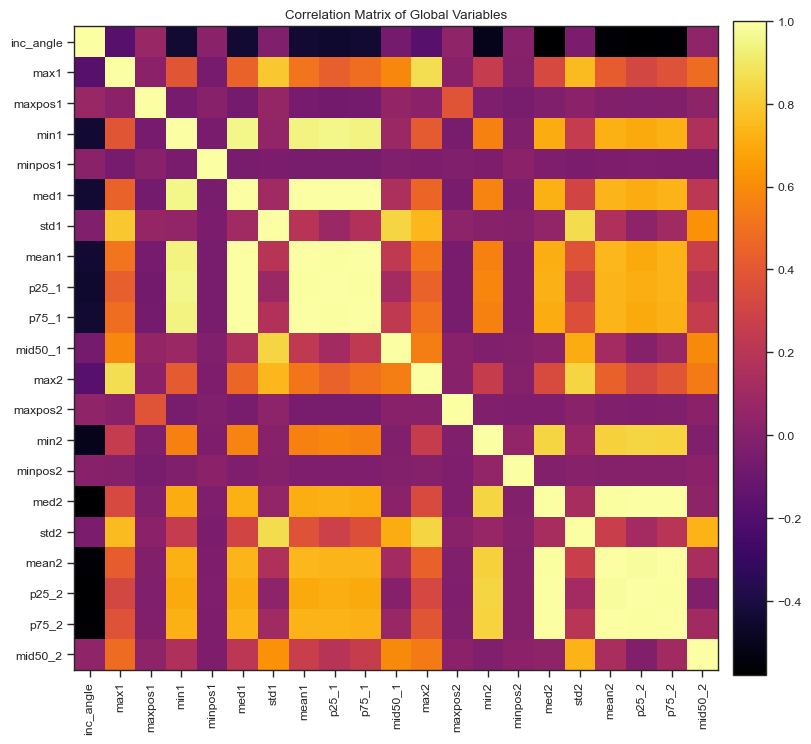

In [32]:
corr = train_stats.corr()
fig = plt.figure(1, figsize=(10,10))
plt.imshow(corr,cmap='inferno')
labels = np.arange(len(train_stats.columns))
plt.xticks(labels,train_stats.columns,rotation=90)
plt.yticks(labels,train_stats.columns)
plt.title('Correlation Matrix of Global Variables')
cbar = plt.colorbar(shrink=0.85,pad=0.02)
plt.show()

In [33]:
icebergs = train[train.is_iceberg==1].sample(n=300,random_state=123)
ships = train[train.is_iceberg==0].sample(n=300,random_state=456)

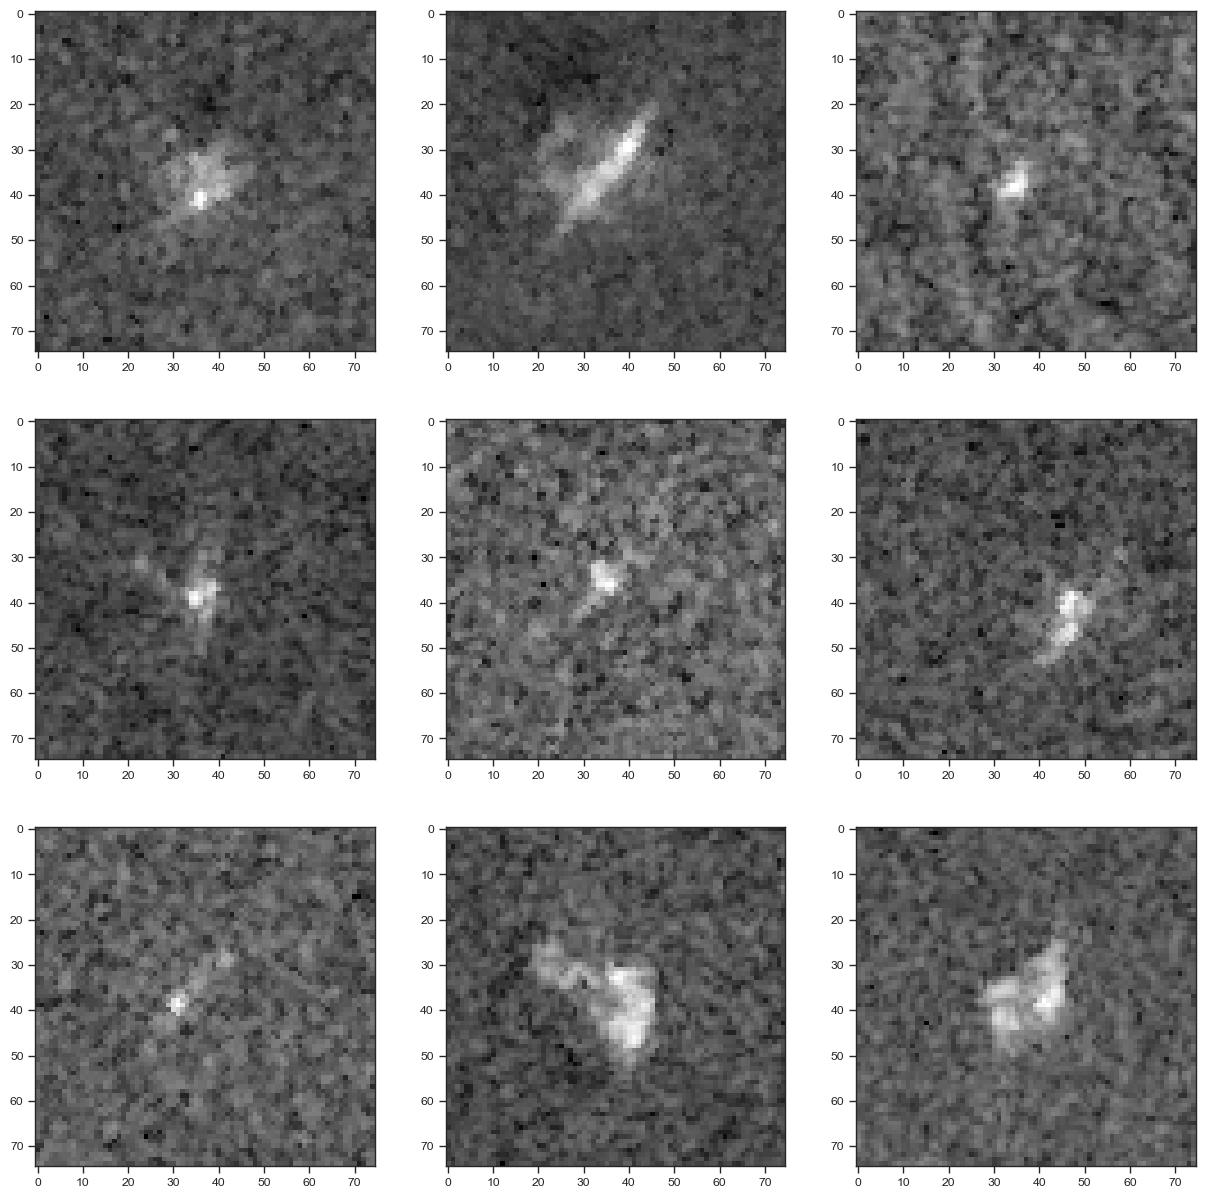

In [34]:
# Plot band_1/band_2 images
fig = plt.figure(1,figsize=(15,15))
for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    arr = np.reshape(np.array(icebergs.iloc[i,1]),(75,75))
    ax.imshow(arr,cmap='gist_gray')
    
plt.show()

In [35]:
def plot_results(images, n_cols=None):
    '''Visualizes fake images'''

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols * 2, n_rows * 2))  # Increase the figure size to accommodate 2-band images

    for index, image in enumerate(images):
        if image.shape[-1] == 1:
            image = np.squeeze(image, axis=-1)
        elif image.shape[-1] == 2:
            # Merge the two bands into a single image
            image = np.dstack((image[:, :, 0], image[:, :, 1]))
            image = np.mean(image, axis=2)  # Convert to grayscale by taking the mean of the two bands
        else:
            raise ValueError("Invalid number of image bands")

        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="inferno")
        plt.axis("off")


In [56]:
# download the training images
X_train = icebergs[['band_1', 'band_2']]
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)
print(X_train[1])
# Remove the first row (column names)
column_names = X_train.iloc[0]
X_train = X_train.iloc[1:]

column_1 = np.array([np.array(image) for image in X_train['band_1']])
column_2 = np.array([np.array(image) for image in X_train['band_2']])

column_1 = column_1.flatten().reshape(-1)
column_2 = column_2.flatten().reshape(-1)

mean_1 = np.mean(column_1)
std_1 = np.std(column_1)

mean_2 = np.mean(column_2)
std_2 = np.std(column_2)

normalized_column_1 = (column_1 - column_1.min()) / (column_1.max() - column_1.min())
normalized_column_2 = (column_2 - column_2.min()) / (column_2.max() - column_2.min())
#normalized_column_1 = (column_1 - mean_1) / std_1
#normalized_column_2 = (column_2 - mean_2) / std_2

X_train_normalized = np.column_stack((normalized_column_1, normalized_column_2))
#print(X_train[0])
# Reshape images 
X_train = X_train_normalized.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Convert X_train to a NumPy array
X_train_array = np.array(X_train)


print(X_train_array.shape)

# create batches of tensors to be fed into the model
dataset = X_train
print(X_train_array.dtype)

[[[-12.242375 -31.50632  -21.874348]
  [-14.920305 -27.984554 -21.45243 ]
  [-14.920363 -26.645678 -20.78302 ]
  ...
  [-10.633402 -25.765633 -18.199516]
  [-11.956054 -24.466875 -18.211464]
  [-14.379026 -25.489983 -19.934505]]

 [[-13.046626 -25.485723 -19.266174]
  [-14.077841 -24.959202 -19.51852 ]
  [-12.728542 -26.340878 -19.53471 ]
  ...
  [-11.243189 -28.358309 -19.800749]
  [-11.786291 -27.9887   -19.887497]
  [-14.379026 -25.76575  -20.072388]]

 [[-15.248114 -24.70742  -19.977768]
  [-14.0779   -28.354282 -21.216091]
  [-12.604514 -26.04647  -19.325493]
  ...
  [-15.680162 -25.489866 -20.585014]
  [-13.51685  -26.649763 -20.083307]
  [-14.454887 -30.487534 -22.47121 ]]

 ...

 [[-15.589596 -27.985373 -21.787483]
  [-16.899685 -26.646496 -21.77309 ]
  [-17.527912 -26.047287 -21.7876  ]
  ...
  [-11.78711  -27.294277 -19.540693]
  [-10.883234 -29.149418 -20.016327]
  [-12.306804 -27.294395 -19.8006  ]]

 [[-14.761801 -29.569056 -22.165428]
  [-15.503286 -27.630913 -21.5671  ]


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [37]:
from scipy import ndimage

def sample_images(noise, subplots, generator, prefix, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    print(generated_images.shape)
    

    plt.figure(figsize=figsize)
    #print(np.amax(generated_images))
    samples = []
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            print(image.shape)
            if image.shape == (64, 64, 2):
                print(image)
                image = ndimage.zoom(image, (75 / 64, 75 / 64, 1), order=1)

            image = np.reshape(np.array(image[:, :, :3]),(75,75))
            plt.imshow(image)

            #channel_1 = image[:, :, 0]
            #channel_2 = image[:, :, 1]

            #plt.subplot(1, 2, 1)
            #plt.imshow(channel_1, cmap='gray')
            #plt.title('Channel 1')

            #plt.subplot(1, 2, 2)
            #plt.imshow(channel_2, cmap='gray')
            #plt.title('Channel 2')

            #plt.show()
            import matplotlib.image
            #print(np.amin(image.reshape((WIDTH, HEIGHT, 3))))
            from skimage import util
            #image = (image - image.min()) / (image.max() - image.min())
            #print(np.min(image))   # minimum value of the image data
            #print(np.max(image))   # maximum value of the image data
            #matplotlib.image.imsave('gen_img'+str(i)+'.png', image)
            #image_data = np.transpose(image, (2, 0, 1))
            # Transpose the array to have shape (height, width, num_channels)
            #image_data = np.transpose(image, (2, 0, 1))
            #print(image.shape)
            # Concatenate the channels along the third axis to create a multi-channel image
            print(image.shape)
            #joined_channels_image = np.concatenate([np.expand_dims(image[:, :, i], axis=0) for i in range(image.shape[2])], axis=0)
            #joined_channels_image = np.transpose(joined_channels_image, (1, 2, 0))  # Transpose dimensions

            samples.append(image)
            #combined_image = np.mean(joined_channels_image, axis=2)

            plt.imshow(image)
            # Save grayscale image as PNG
            plt.imsave(prefix + '_gen_img' + str(i) + '.png', image, cmap='inferno')

        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    return samples

In [38]:
noise_dcgan = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
noise_wgan = tf.random.normal([32, 75*75*2])
generator_dcgan, discriminator_dcgan, dcgan_model = dcgan.build(OPTIMIZER, NOISE_DIM)
generator_dcgan_loss_values = dcgan.train(generator_dcgan, discriminator_dcgan, dcgan_model, noise_dcgan, EPOCHS, STEPS, BATCH_SIZE, NOISE_DIM, X_train_array)
generator_wgan, generator_wgan_loss_values = wgan.train(EPOCHS, STEPS, BATCH_SIZE, NOISE_DIM, X_train_array)




Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_301 (Conv2D)         (None, 75, 75, 64)        1216      
                                                                 
 leaky_re_lu_23 (LeakyReLU)  (None, 75, 75, 64)        0         
                                                                 
 conv2d_302 (Conv2D)         (None, 38, 38, 75)        43275     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 38, 38, 75)        0         
                                                                 
 conv2d_303 (Conv2D)         (None, 19, 19, 75)        50700     
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 19, 19, 75)        0         
                                                                 
 conv2d_304 (Conv2D)         (None, 10, 10, 75)    

  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 253ms/step


 20%|██        | 1/5 [00:02<00:09,  2.46s/it]

1/1 [==============================] - 0s 164ms/step


 40%|████      | 2/5 [00:03<00:04,  1.50s/it]

1/1 [==============================] - 0s 168ms/step


 60%|██████    | 3/5 [00:04<00:02,  1.18s/it]

1/1 [==============================] - 0s 185ms/step


 80%|████████  | 4/5 [00:04<00:01,  1.05s/it]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


EPOCH: 1 Generator Loss: 0.6922 Discriminator Loss: 0.6466


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████      | 2/5 [00:01<00:02,  1.16it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.19it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 176ms/step


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


EPOCH: 2 Generator Loss: 0.5356 Discriminator Loss: 0.5103


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 167ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

1/1 [==============================] - 0s 175ms/step


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


EPOCH: 3 Generator Loss: 0.5885 Discriminator Loss: 0.6438


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 177ms/step


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 157ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 157ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 162ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 4 Generator Loss: 0.7513 Discriminator Loss: 0.7201


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 140ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 167ms/step


 40%|████      | 2/5 [00:01<00:02,  1.20it/s]

1/1 [==============================] - 0s 159ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

1/1 [==============================] - 0s 166ms/step


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


EPOCH: 5 Generator Loss: 0.8481 Discriminator Loss: 0.7137


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

1/1 [==============================] - 0s 157ms/step


 40%|████      | 2/5 [00:01<00:02,  1.26it/s]

1/1 [==============================] - 0s 175ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 174ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 144ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 6 Generator Loss: 0.7569 Discriminator Loss: 0.6986


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 147ms/step


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

1/1 [==============================] - 0s 172ms/step


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 164ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 7 Generator Loss: 0.6214 Discriminator Loss: 0.7422


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 160ms/step


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 165ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 158ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 8 Generator Loss: 0.7783 Discriminator Loss: 0.6976


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 164ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 161ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 174ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 163ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 9 Generator Loss: 0.8523 Discriminator Loss: 0.6662


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 160ms/step


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

1/1 [==============================] - 0s 157ms/step


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 158ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 10 Generator Loss: 0.7117 Discriminator Loss: 0.7077


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 175ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 11 Generator Loss: 0.7841 Discriminator Loss: 0.6742


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

1/1 [==============================] - 0s 167ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 145ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 157ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 12 Generator Loss: 0.6071 Discriminator Loss: 0.6880


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 148ms/step


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

1/1 [==============================] - 0s 164ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 176ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 174ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 163ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 13 Generator Loss: 0.7194 Discriminator Loss: 0.6956


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 150ms/step


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]

1/1 [==============================] - 0s 168ms/step


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 167ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 159ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 14 Generator Loss: 0.7274 Discriminator Loss: 0.6969


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 161ms/step


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]

1/1 [==============================] - 0s 184ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.19it/s]

1/1 [==============================] - 0s 150ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

1/1 [==============================] - 0s 169ms/step


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


EPOCH: 15 Generator Loss: 0.7240 Discriminator Loss: 0.6786


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

1/1 [==============================] - 0s 173ms/step


 40%|████      | 2/5 [00:01<00:02,  1.13it/s]

1/1 [==============================] - 0s 148ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.19it/s]

1/1 [==============================] - 0s 160ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

1/1 [==============================] - 0s 151ms/step


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


EPOCH: 16 Generator Loss: 0.6794 Discriminator Loss: 0.7317


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 165ms/step


 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

1/1 [==============================] - 0s 169ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 149ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

1/1 [==============================] - 0s 165ms/step


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


EPOCH: 17 Generator Loss: 0.7335 Discriminator Loss: 0.6875


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

1/1 [==============================] - 0s 161ms/step


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

1/1 [==============================] - 0s 174ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 144ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

1/1 [==============================] - 0s 157ms/step


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


EPOCH: 18 Generator Loss: 0.7262 Discriminator Loss: 0.6866


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.26it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 178ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 154ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

1/1 [==============================] - 0s 158ms/step


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


EPOCH: 19 Generator Loss: 0.8966 Discriminator Loss: 0.6675


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 149ms/step


 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

1/1 [==============================] - 0s 152ms/step


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]

1/1 [==============================] - 0s 157ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 146ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 157ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 20 Generator Loss: 0.6751 Discriminator Loss: 0.6896


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 160ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 151ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 159ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 21 Generator Loss: 0.5571 Discriminator Loss: 0.7506


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

1/1 [==============================] - 0s 157ms/step


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

1/1 [==============================] - 0s 153ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 149ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

1/1 [==============================] - 0s 182ms/step


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


EPOCH: 22 Generator Loss: 0.8657 Discriminator Loss: 0.7086


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 164ms/step


 20%|██        | 1/5 [00:00<00:03,  1.13it/s]

1/1 [==============================] - 0s 165ms/step


 40%|████      | 2/5 [00:01<00:02,  1.15it/s]

1/1 [==============================] - 0s 158ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

1/1 [==============================] - 0s 145ms/step


100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


EPOCH: 23 Generator Loss: 0.7112 Discriminator Loss: 0.6845


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 175ms/step


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]

1/1 [==============================] - 0s 148ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 163ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 160ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 24 Generator Loss: 0.6088 Discriminator Loss: 0.7049


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

1/1 [==============================] - 0s 178ms/step


 40%|████      | 2/5 [00:01<00:02,  1.19it/s]

1/1 [==============================] - 0s 168ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 142ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 162ms/step


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


EPOCH: 25 Generator Loss: 0.6545 Discriminator Loss: 0.7067


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 162ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 153ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 161ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 26 Generator Loss: 0.8463 Discriminator Loss: 0.6833


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 148ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 158ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 27 Generator Loss: 0.6807 Discriminator Loss: 0.7062


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]

1/1 [==============================] - 0s 157ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 182ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.17it/s]

1/1 [==============================] - 0s 159ms/step


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


EPOCH: 28 Generator Loss: 0.7408 Discriminator Loss: 0.7010


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 163ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 147ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 29 Generator Loss: 0.6289 Discriminator Loss: 0.7020


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 30 Generator Loss: 0.7750 Discriminator Loss: 0.6772


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 169ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 160ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

1/1 [==============================] - 0s 157ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 31 Generator Loss: 0.6408 Discriminator Loss: 0.7355


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

1/1 [==============================] - 0s 158ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 158ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 32 Generator Loss: 0.8421 Discriminator Loss: 0.6732


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 163ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

1/1 [==============================] - 0s 157ms/step


100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


EPOCH: 33 Generator Loss: 0.6077 Discriminator Loss: 0.7531


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 169ms/step


 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]

1/1 [==============================] - 0s 169ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 154ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

1/1 [==============================] - 0s 160ms/step


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


EPOCH: 34 Generator Loss: 0.7432 Discriminator Loss: 0.6778


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 155ms/step


 20%|██        | 1/5 [00:00<00:03,  1.20it/s]

1/1 [==============================] - 0s 169ms/step


 40%|████      | 2/5 [00:01<00:02,  1.17it/s]

1/1 [==============================] - 0s 144ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 158ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.20it/s]

1/1 [==============================] - 0s 175ms/step


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


EPOCH: 35 Generator Loss: 0.7986 Discriminator Loss: 0.7091


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1/5 [00:00<00:03,  1.23it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]

1/1 [==============================] - 0s 157ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 153ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 160ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 36 Generator Loss: 0.6882 Discriminator Loss: 0.7075


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 159ms/step


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]

1/1 [==============================] - 0s 161ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 160ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 150ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 37 Generator Loss: 0.6567 Discriminator Loss: 0.6758


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

1/1 [==============================] - 0s 172ms/step


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]

1/1 [==============================] - 0s 153ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

1/1 [==============================] - 0s 158ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 38 Generator Loss: 0.7553 Discriminator Loss: 0.6775


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 153ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 158ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 154ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 39 Generator Loss: 0.7150 Discriminator Loss: 0.7048


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 1/5 [00:00<00:03,  1.17it/s]

1/1 [==============================] - 0s 165ms/step


 40%|████      | 2/5 [00:01<00:02,  1.18it/s]

1/1 [==============================] - 0s 159ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 168ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.17it/s]

1/1 [==============================] - 0s 151ms/step


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


EPOCH: 40 Generator Loss: 0.8279 Discriminator Loss: 0.6735


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 154ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 147ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 144ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 152ms/step


100%|██████████| 5/5 [00:04<00:00,  1.22it/s]


EPOCH: 41 Generator Loss: 0.7602 Discriminator Loss: 0.7260


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 161ms/step


 20%|██        | 1/5 [00:00<00:03,  1.15it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 2/5 [00:01<00:02,  1.21it/s]

1/1 [==============================] - 0s 159ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.18it/s]

1/1 [==============================] - 0s 175ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


EPOCH: 42 Generator Loss: 0.6813 Discriminator Loss: 0.6871


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 159ms/step


 20%|██        | 1/5 [00:00<00:03,  1.22it/s]

1/1 [==============================] - 0s 144ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 153ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 154ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 149ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 43 Generator Loss: 0.6914 Discriminator Loss: 0.6516


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 161ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 44 Generator Loss: 0.7607 Discriminator Loss: 0.7346


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 154ms/step


 20%|██        | 1/5 [00:00<00:03,  1.21it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 159ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 155ms/step


100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


EPOCH: 45 Generator Loss: 0.6256 Discriminator Loss: 0.6405


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 163ms/step


 20%|██        | 1/5 [00:00<00:03,  1.19it/s]

1/1 [==============================] - 0s 147ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 168ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.19it/s]

1/1 [==============================] - 0s 152ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

1/1 [==============================] - 0s 143ms/step


100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


EPOCH: 46 Generator Loss: 0.8167 Discriminator Loss: 0.7127


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 158ms/step


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

1/1 [==============================] - 0s 153ms/step


 40%|████      | 2/5 [00:01<00:02,  1.22it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.23it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 158ms/step


100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


EPOCH: 47 Generator Loss: 0.7359 Discriminator Loss: 0.7058


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.25it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 174ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

1/1 [==============================] - 0s 155ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 48 Generator Loss: 0.5757 Discriminator Loss: 0.6401


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


 20%|██        | 1/5 [00:00<00:03,  1.24it/s]

1/1 [==============================] - 0s 156ms/step


 40%|████      | 2/5 [00:01<00:02,  1.23it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

1/1 [==============================] - 0s 153ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

1/1 [==============================] - 0s 156ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 49 Generator Loss: 0.7563 Discriminator Loss: 0.6857


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 152ms/step


 20%|██        | 1/5 [00:00<00:03,  1.27it/s]

1/1 [==============================] - 0s 162ms/step


 40%|████      | 2/5 [00:01<00:02,  1.24it/s]

1/1 [==============================] - 0s 161ms/step


 60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

1/1 [==============================] - 0s 153ms/step


 80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

1/1 [==============================] - 0s 146ms/step


100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


EPOCH: 50 Generator Loss: 0.7785 Discriminator Loss: 0.6994
0
critic range 0
critic range 1
critic range 2
critic range 3
critic range 4
critic range 0
critic range 1
critic range 2
critic range 3
critic range 4
critic range 0
critic range 1
critic range 2
critic range 3
critic range 4
Epoch 1/50, Critic Loss: -2.8982, Generator Loss: 0.9917
1
Epoch 2/50, Critic Loss: -2.8558, Generator Loss: 0.6931
2
Epoch 3/50, Critic Loss: -2.8617, Generator Loss: -4.8492
3
Epoch 4/50, Critic Loss: -1.5151, Generator Loss: 0.0814
4
Epoch 5/50, Critic Loss: -2.1890, Generator Loss: -7.8171
5
Epoch 6/50, Critic Loss: -1.7488, Generator Loss: -6.3604
6
Epoch 7/50, Critic Loss: -1.6017, Generator Loss: -0.0952
7
Epoch 8/50, Critic Loss: -2.4609, Generator Loss: -3.4530
8
Epoch 9/50, Critic Loss: -1.6746, Generator Loss: 5.5506
9
Epoch 10/50, Critic Loss: -1.7836, Generator Loss: 5.3293
10
Epoch 11/50, Critic Loss: -1.4836, Generator Loss: 5.1938
11
Epoch 12/50, Critic Loss: -0.8243, Generator Loss: 4.47

In [39]:
import importlib 
importlib.reload(prgan) 
import prgan as prgan

generator_prgan, generator_prgan_loss_values = prgan.build(X_train_array)

C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
C:\Users\flopes1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Scaled Data (75, 32, 32, 2)
1/1 [==============================] - 0s 118ms/step
>1, d1=-0.004, d2=0.007 g=0.023
VALUE ADDED 0.023413321003317833 0
1/1 [==============================] - 0s 50ms/step
>6, d1=-1.355, d2=1.772 g=-0.847
VALUE ADDED -0.8466408252716064 5
1/1 [==============================] - 0s 51ms/step
>11, d1=-0.954, d2=1.412 g=-0.793
VALUE ADDED -0.7929075956344604 10
1/1 [==============================] - 0s 55ms/step
>16, d1=-0.488, d2=0.771 g=-0.469
VALUE ADDED -0.4689023792743683 15
1/1 [==============================] - 0s 51ms/step
>21, d1=-0.243, d2=0.400 g=-0.252
VALUE ADDED -0.25171810388565063 20
1/1 [==============================] - 0s 55ms/step
>26, d1=-0.119, d2=0.204 g=-0.127
VALUE ADDED -0.12681768834590912 25
1/1 [==============================] - 0s 51ms/step
>31, d1=-0.053, d2=0.099 g=-0.055
VALUE ADDED -0.05483177676796913 30
1/1 [==============================] - 0s 55ms/step
>36, d1=-0.017, d2=0.043 g=-0.014
VALUE ADDED -0.014436345547437668 35
1/

In [40]:
import seaborn as sns

(60, 1)
New Shape:  (60, 1)
(50, 1)
New Shape:  (50, 1)


C:\Users\flopes1\AppData\Local\Temp\ipykernel_21788\113228889.py:62: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(df_combined, ci='sd', markers=False)


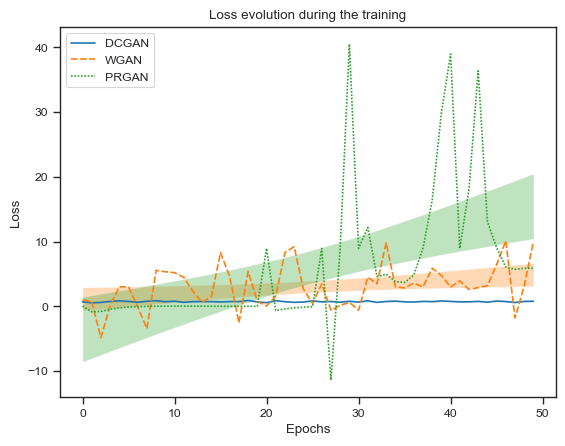

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]


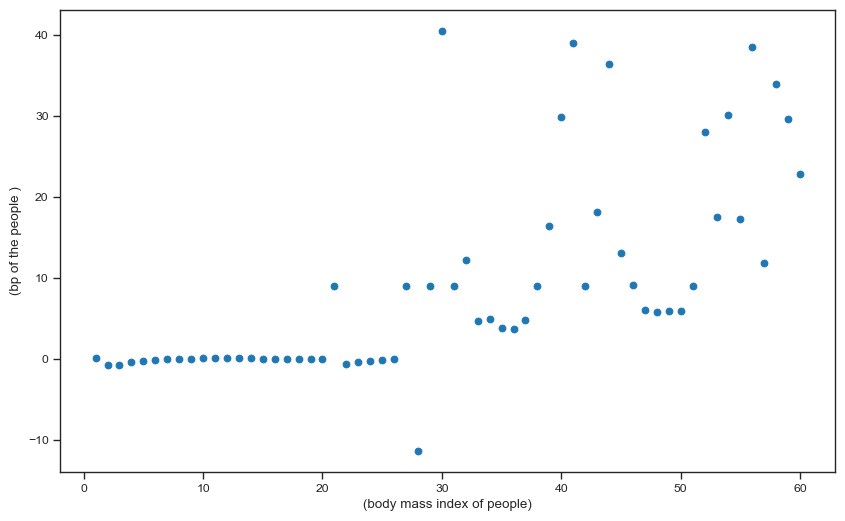

In [41]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
import numpy as np
 
def outlier_removal(array):
    if array is not pd.DataFrame:
        array = np.array(array)
        df = pd.DataFrame(array)
    df.head()
    print(df.shape)
    # IQR
    # Calculate the upper and lower limits
    Q1 = df.quantile(0.30)
    Q3 = df.quantile(0.70)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    
    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(df>=upper)[0]
    lower_array = np.where(df<=lower)[0]
    
    # Replace outlier values with NaN
    df.iloc[upper_array] = np.nan
    df.iloc[lower_array] = np.nan
    
    # Replace NaN values with the mean
    df = df.fillna(df.mean())
    
    # Print the new shape of the DataFrame
    print("New Shape: ", df.shape)

    return df

df_generator_prgan_loss_values = outlier_removal(generator_prgan_loss_values)
df_generator_prgan_loss_values.rename(columns={df_generator_prgan_loss_values.columns[0]: 'PRGAN'}, inplace=True)

df_generator_wgan_loss_values = outlier_removal(generator_wgan_loss_values)
df_generator_wgan_loss_values.rename(columns={df_generator_wgan_loss_values.columns[0]: 'WGAN'}, inplace=True)

array_generator_dcgan_loss_values = np.array(generator_dcgan_loss_values)
df_generator_dcgan_loss_values = pd.DataFrame(array_generator_dcgan_loss_values, columns=['DCGAN'])


df_combined = pd.concat([df_generator_dcgan_loss_values, df_generator_wgan_loss_values, df_generator_prgan_loss_values[:50]], axis=1)
# Set Seaborn style
sns.set_style("ticks")
sns.set_context("paper")

# Calculate the confidence interval
# Calculate and add the confidence intervals for each line
for column in df_combined.columns:
    model = sm.OLS(df_combined[column], sm.add_constant(df_combined.index))
    results = model.fit()
    predictions = results.get_prediction(sm.add_constant(df_combined.index))
    conf_int = predictions.conf_int(alpha=0.05)
    
    plt.fill_between(df_combined.index, conf_int[:, 0], conf_int[:, 1], alpha=0.3)

sns.lineplot(df_combined, ci='sd', markers=False)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss evolution during the training')

# Adding a legend
plt.legend()

# Displaying the plot
plt.savefig("chart-loss.pdf", format="pdf")
plt.show()



output = [i for i in range(1, len(df_generator_prgan_loss_values)+1)]
print(output)
# Scatter plot
fig, ax = plt.subplots(figsize = (10,6))
ax.scatter(output, df_generator_prgan_loss_values)
 
# x-axis label
ax.set_xlabel('(body mass index of people)')
 
# y-axis label
ax.set_ylabel('(bp of the people )')
plt.show()



4/4 [==============================] - 1s 132ms/step
(100, 75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 7

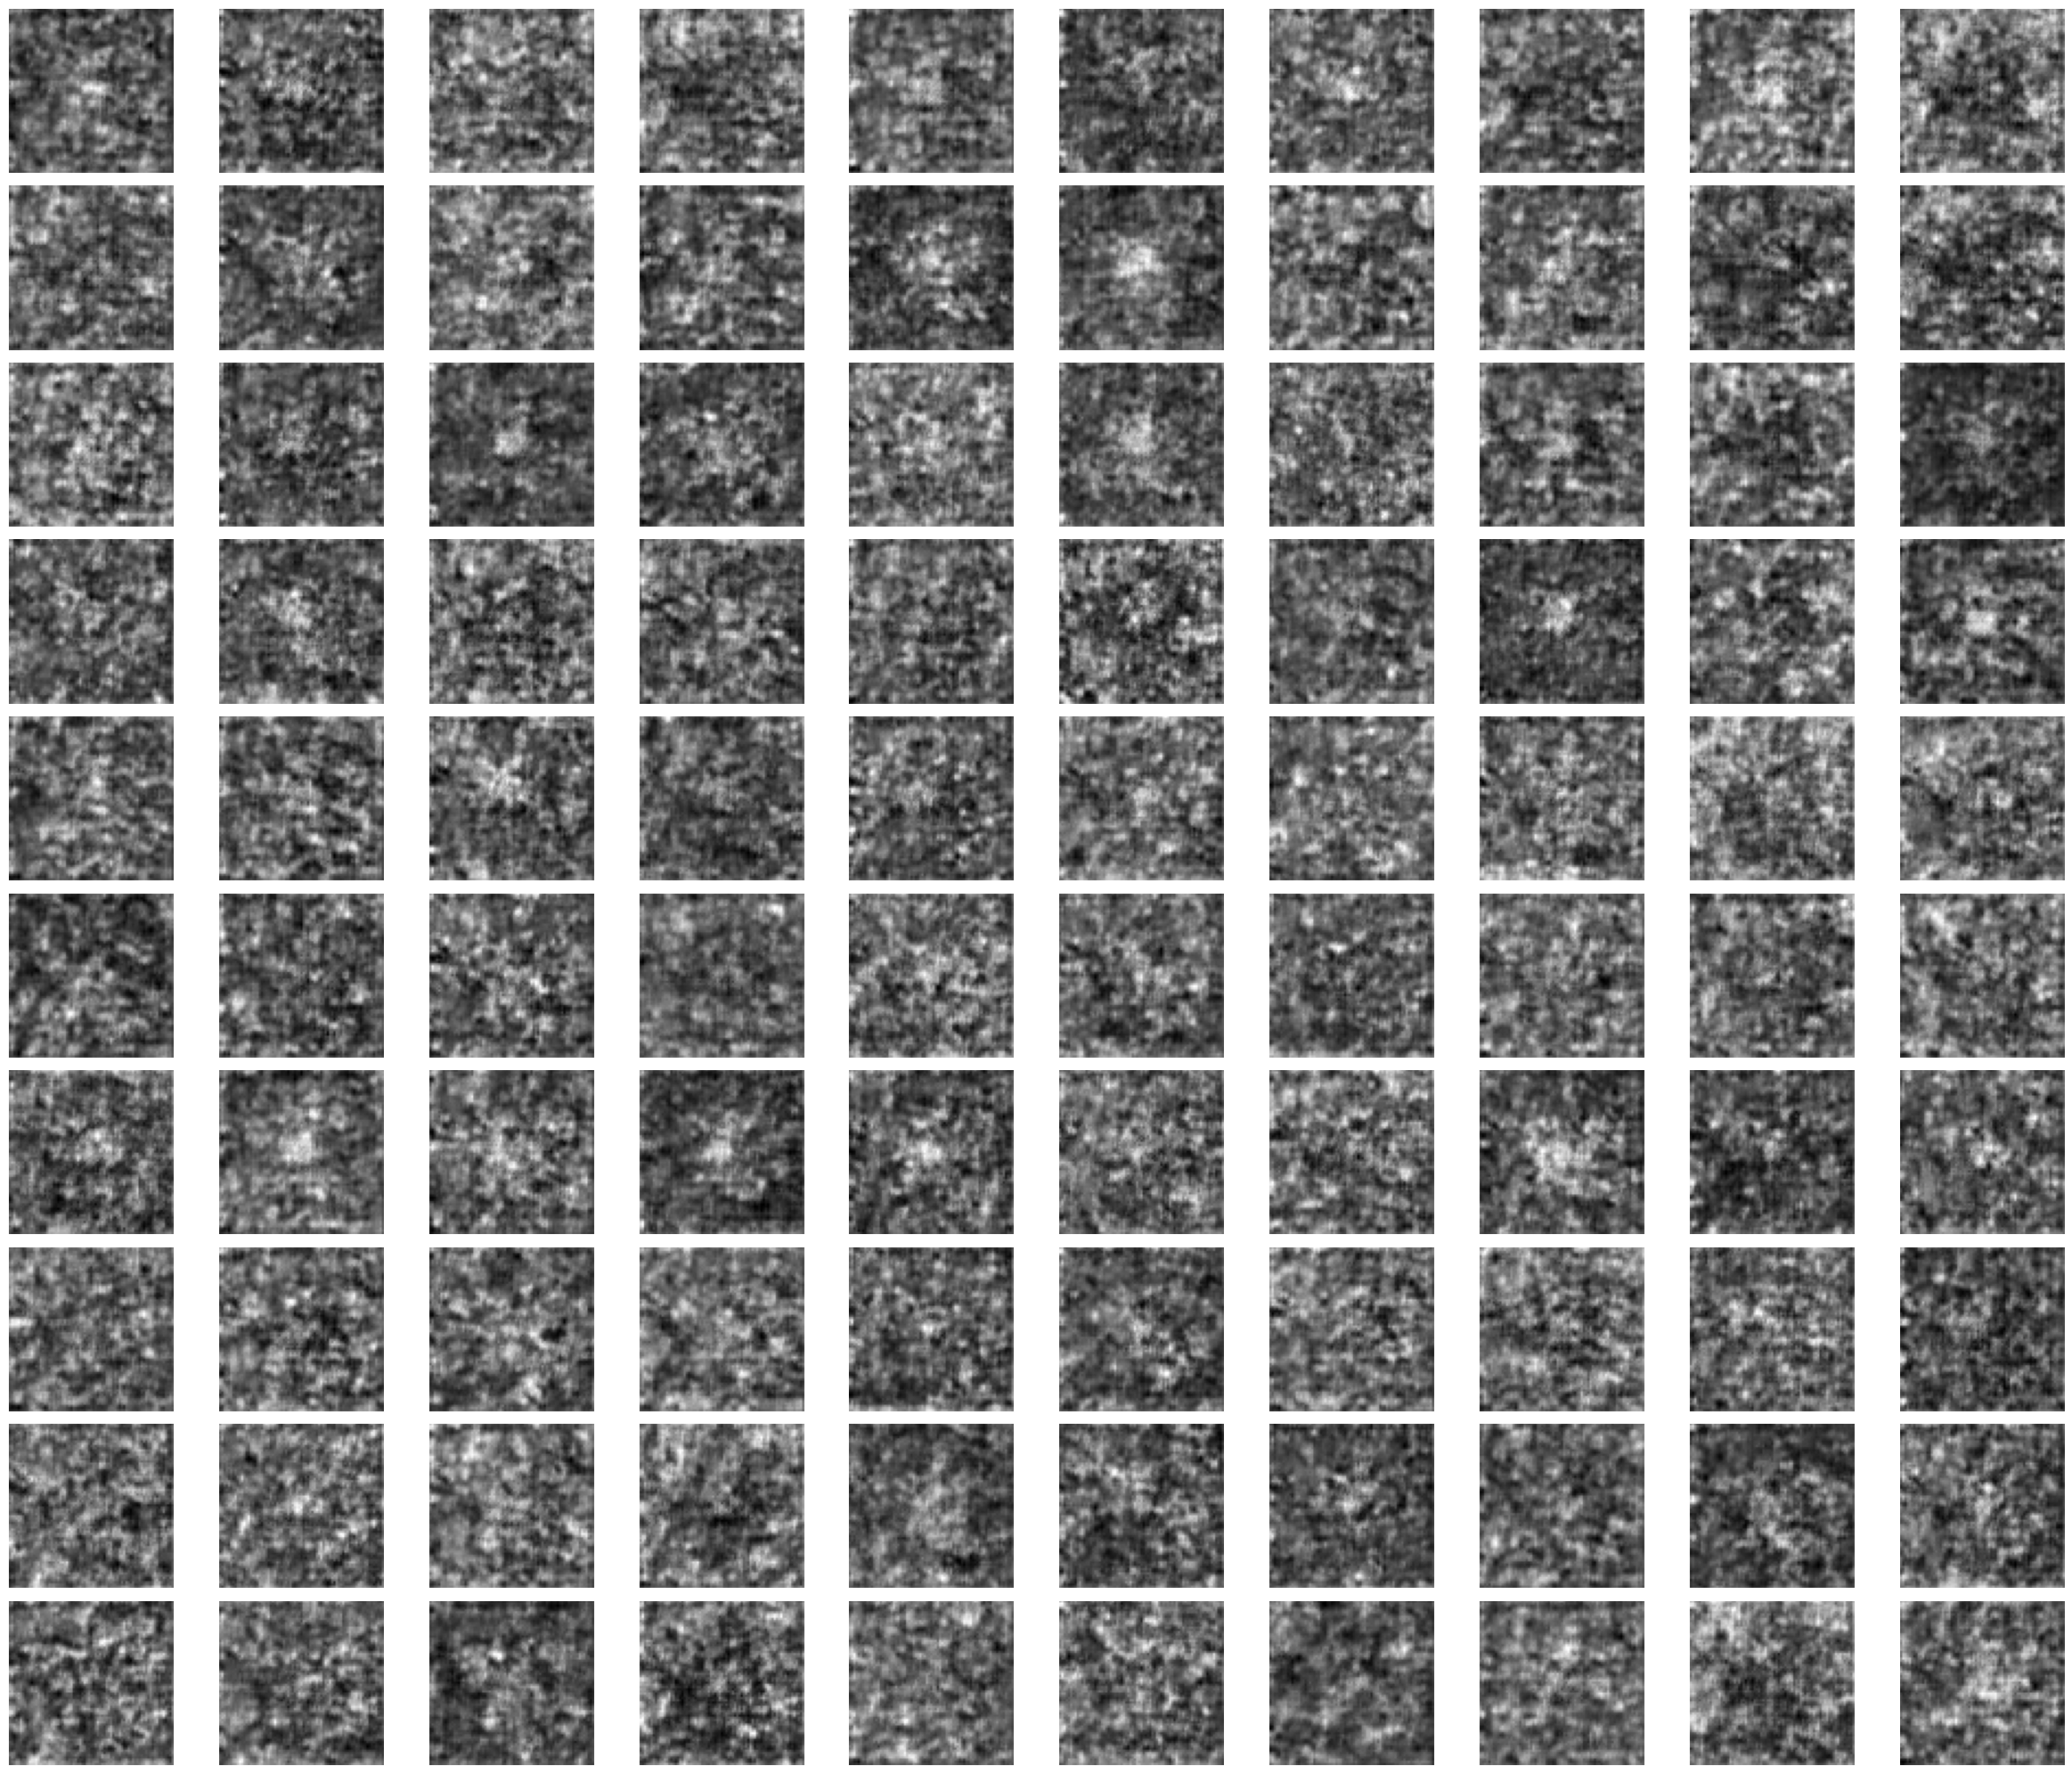

1/1 [==============================] - 0s 340ms/step
(10, 75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)
(75, 75, 2)


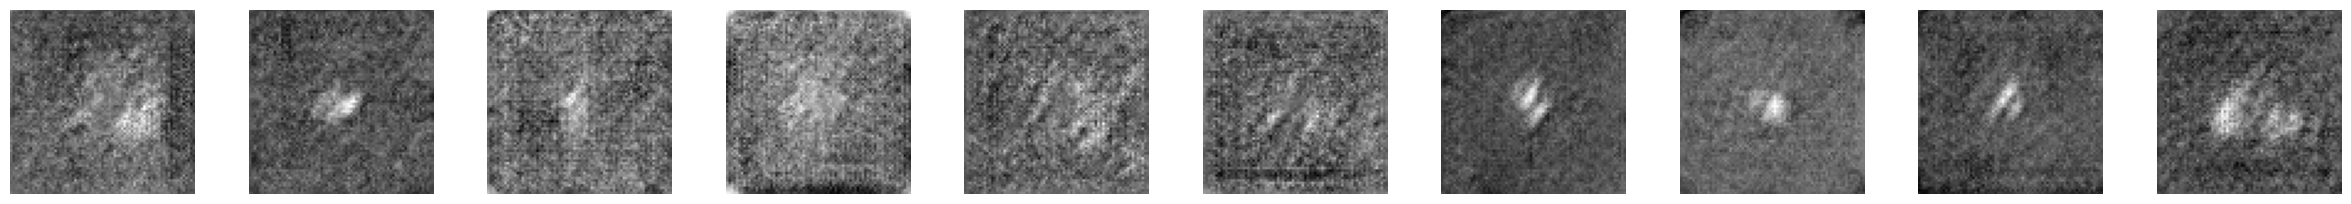

In [42]:
from numpy.random import randn

noise_dcgan = np.random.normal(0, 1, size=(100, NOISE_DIM))
noise_wgan = tf.random.normal([10, 75*75*2])

samples_dcgan = sample_images(noise_dcgan, (10,10), generator_dcgan, 'dcgan', (24,20), save=True)
samples_wgan = sample_images(noise_wgan, (10,10), generator_wgan, 'wgan', (24,20), save=True)


1/1 [==============================] - 0s 96ms/step
(10, 64, 64, 2)
(64, 64, 2)
[[[-1.0010437  -1.0245925 ]
  [-1.0334923  -1.0116692 ]
  [-1.0303406  -1.0060992 ]
  ...
  [-1.0335405  -1.0173303 ]
  [-1.0257379  -1.0276777 ]
  [-0.9948335  -0.97877544]]

 [[-0.9902759  -1.0126003 ]
  [-1.0323218  -1.0185416 ]
  [-1.0236436  -1.017885  ]
  ...
  [-1.0185215  -1.0165488 ]
  [-1.017305   -1.0134878 ]
  [-0.9932666  -0.98289514]]

 [[-0.9905723  -1.0086445 ]
  [-1.028742   -1.0213227 ]
  [-1.02136    -1.0230876 ]
  ...
  [-1.0141187  -1.0184876 ]
  [-1.0173432  -1.0136435 ]
  [-0.9967826  -0.9977261 ]]

 ...

 [[-0.98621273 -1.0165495 ]
  [-1.0256183  -1.01919   ]
  [-1.024661   -1.0225387 ]
  ...
  [-1.0243324  -1.0163879 ]
  [-1.026572   -1.0211724 ]
  [-1.014835   -0.9973855 ]]

 [[-0.99253476 -1.0170983 ]
  [-1.0266358  -1.0224159 ]
  [-1.0375313  -1.0253497 ]
  ...
  [-1.0385594  -1.0237093 ]
  [-1.0364844  -1.0273814 ]
  [-1.0107677  -0.99557966]]

 [[-0.9439966  -0.9696258 ]
  [-0.

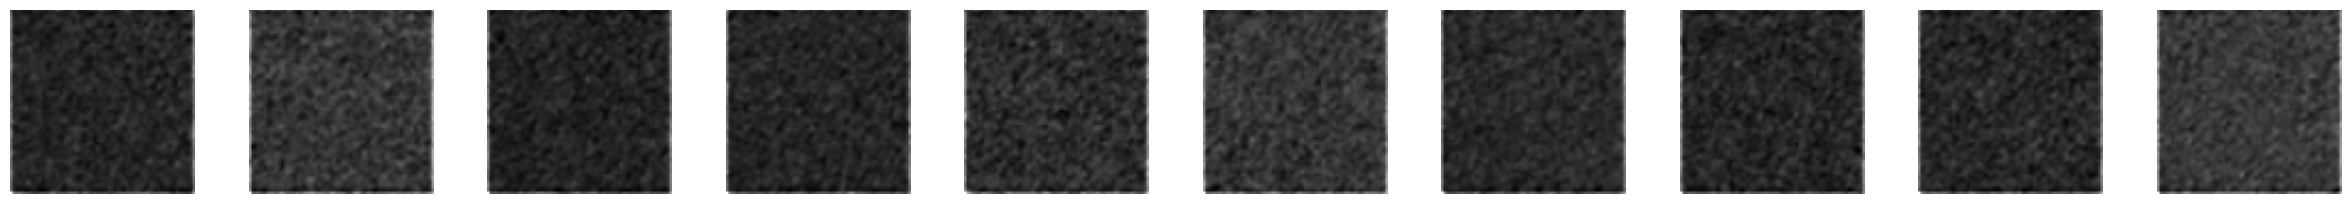

In [43]:
noise_prgan = randn(100 * 10)
# reshape into a batch of inputs for the network
noise_prgan = noise_prgan.reshape(10, 100)
samples_prgan = sample_images(noise_prgan, (10,10), generator_prgan, 'prgan', (24,20), save=True)

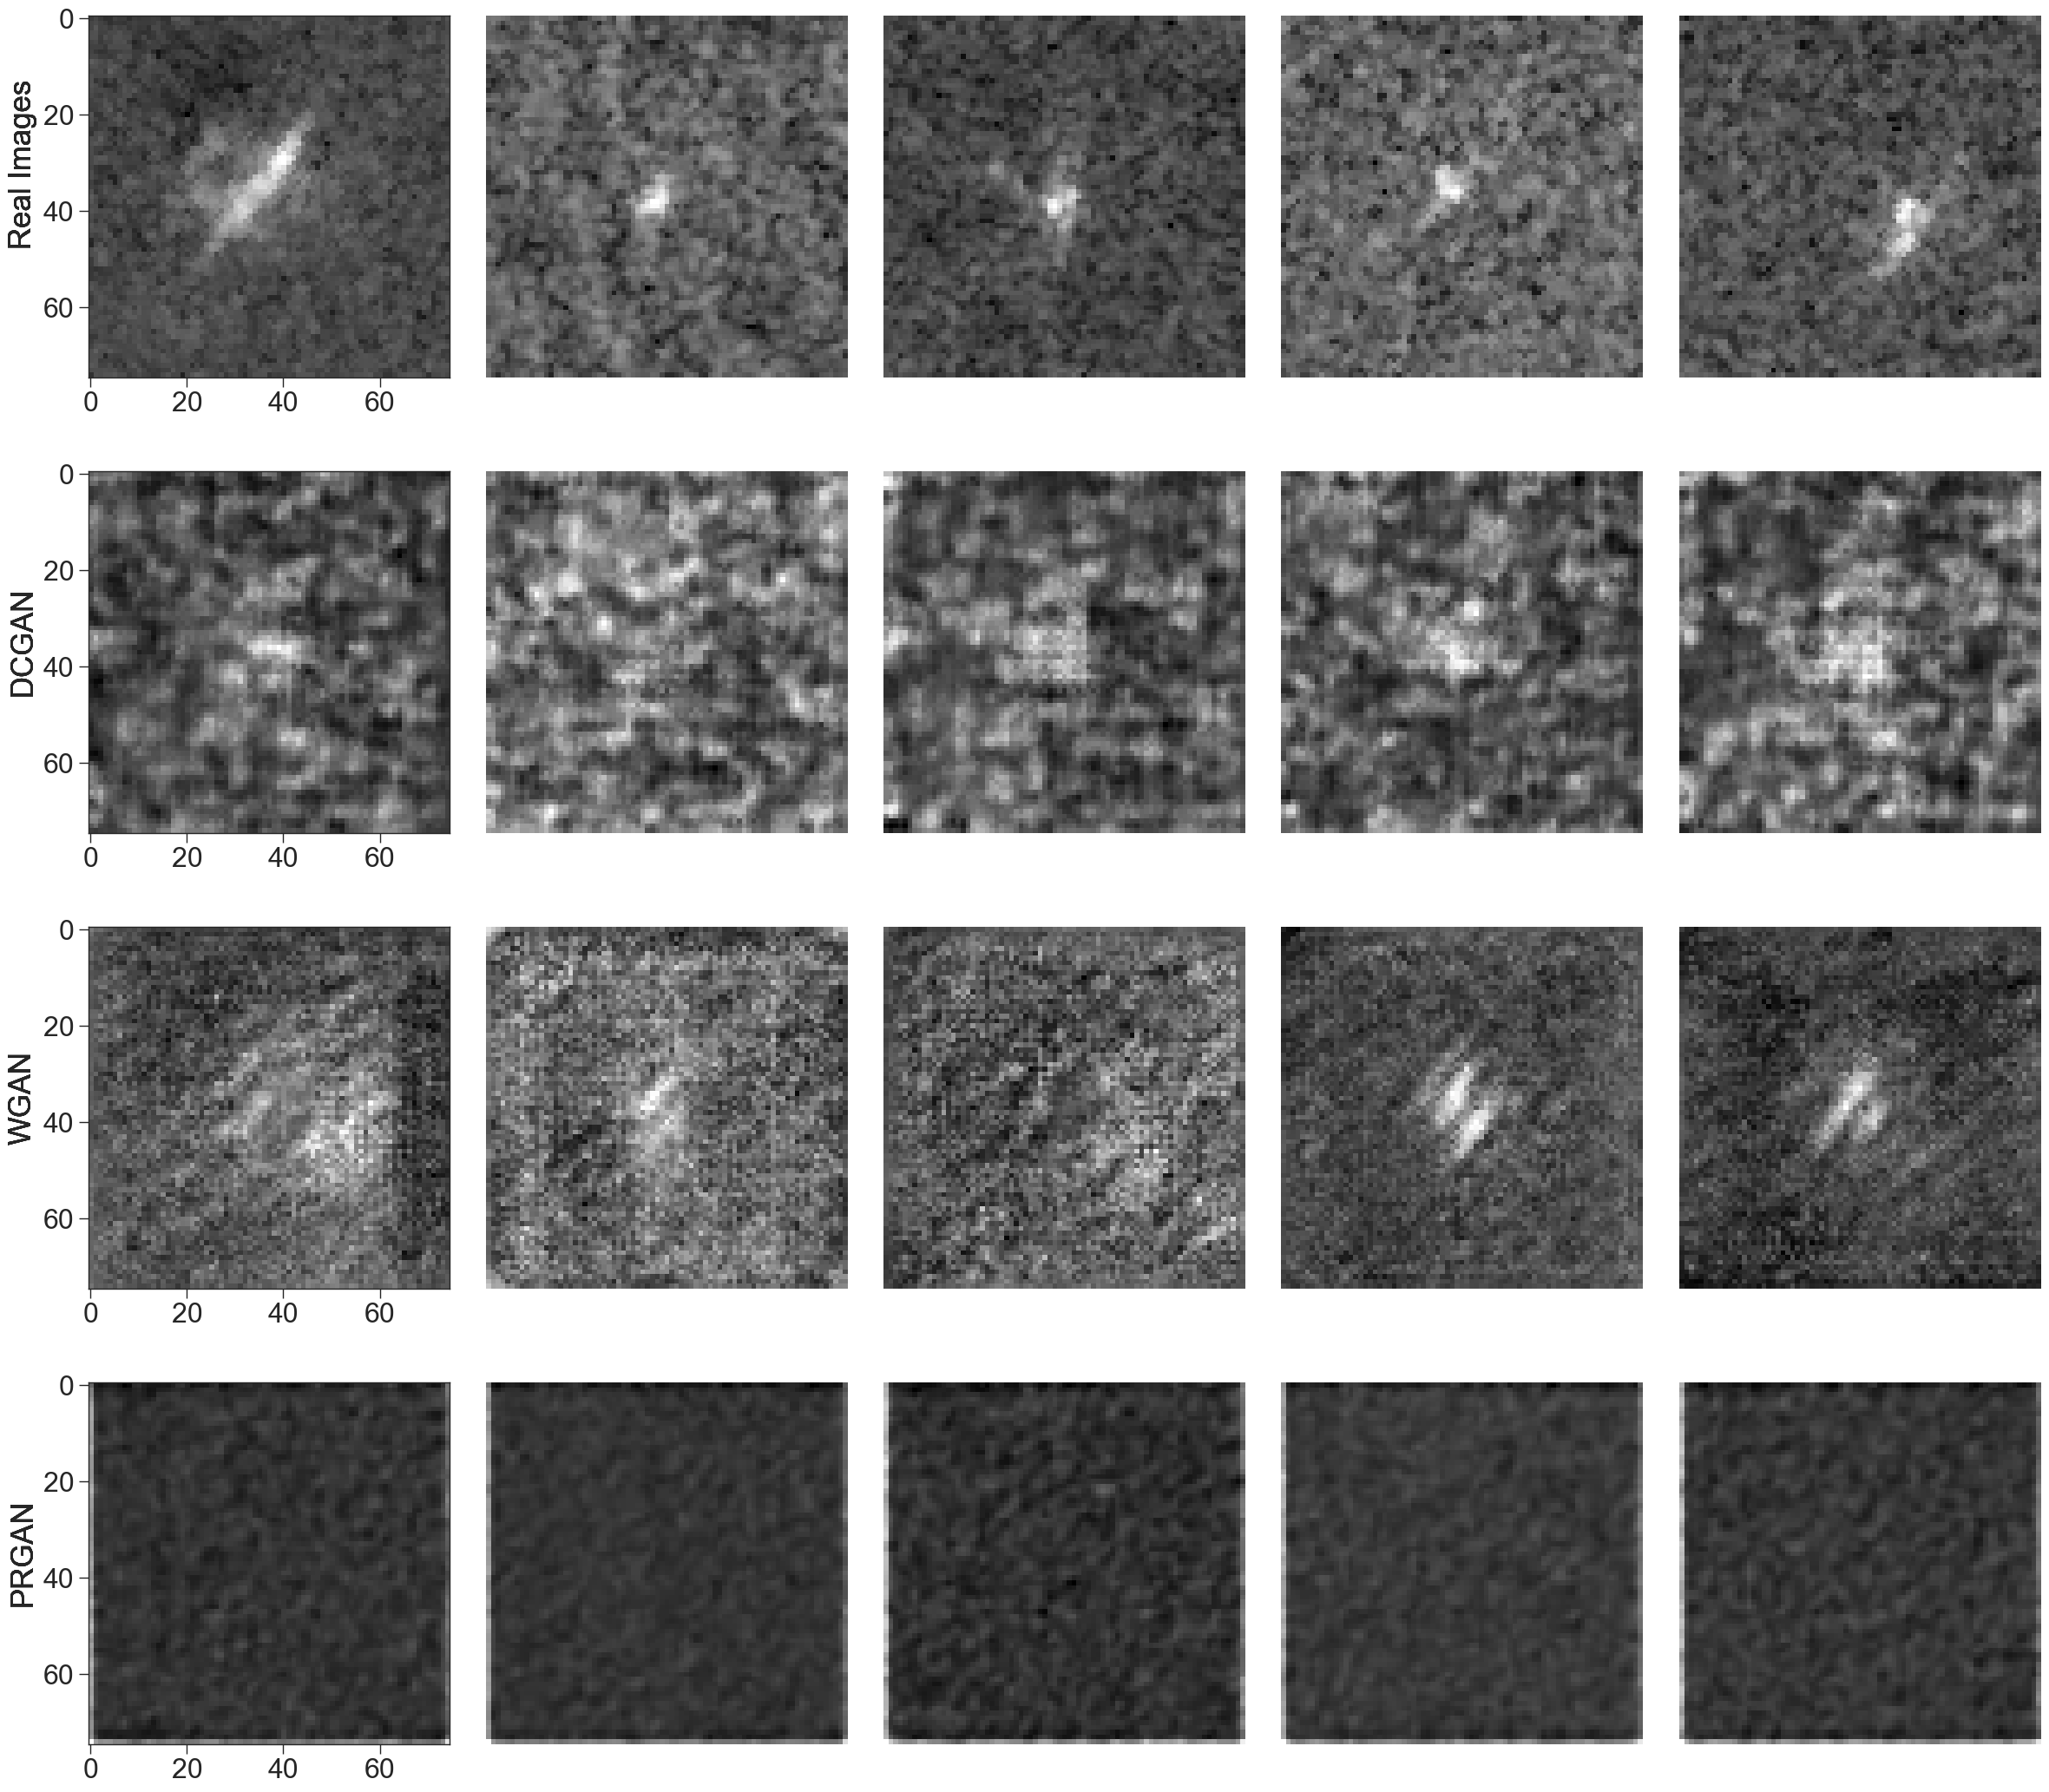

In [44]:
# Create a figure and a set of subplots
fig, axes = plt.subplots(4, 5, figsize=(25, 25))
# Titles for each row
titles = ["Real Images", "DCGAN", "WGAN", "PRGAN"]

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.08, wspace=0.1, hspace=0.0)

# Iterate through rows and columns to plot images
for i in range(4):
    # Set the title for the entire row
    
    for j in range(5):
        if i == 0:
            axes[i, j].axis("off")
            fig.text(0.02, 0.83 - i * 0.25, titles[i], va='center', ha='center', rotation='vertical', fontsize=25)
            axes[i, j].imshow(X_train_array[j][:, :, 0], cmap='gray')
            if j == 0:
                axes[i, j].axis("on")
        elif i == 1:
            axes[i, j].axis("off")
            fig.text(0.02, 0.86 - i * 0.25, titles[i], va='center', ha='center', rotation='vertical', fontsize=25)
            axes[i, j].imshow(samples_dcgan[(j * 2) % len(samples_dcgan)][:, :, 0], cmap='gray')
            if j == 0:
                axes[i, j].axis("on")
        elif i == 2:
            axes[i, j].axis("off")
            fig.text(0.02, 0.9 - i * 0.25, titles[i], va='center', ha='center', rotation='vertical', fontsize=25)
            axes[i, j].imshow(samples_wgan[(j * 2) % len(samples_wgan)][:, :, 0], cmap='gray')
            if j == 0:
                axes[i, j].axis("on")
        elif i == 3:
            axes[i, j].axis("off")
            fig.text(0.02, 0.94 - i * 0.25, titles[i], va='center', ha='center', rotation='vertical', fontsize=25)
            axes[i, j].imshow(samples_prgan[(j * 2) % len(samples_prgan)][:, :, 0], cmap='gray')
            if j == 0:
                axes[i, j].axis("on")

        
        axes[i, j].tick_params(axis='both', which='both', labelsize=23, length=8)


plt.show()

In [45]:
samples_dcgan_array = np.array(samples_dcgan)
samples_wgan_array = np.array(samples_wgan)
samples_prgan_array = np.array(samples_prgan)
X_train_array = np.array(X_train)

samples_dcgan_array = preprocess_array(samples_dcgan_array)
samples_wgan_array = preprocess_array(samples_wgan_array)
samples_prgan_array = preprocess_array(samples_prgan_array)
X_train_array = preprocess_array(X_train_array)


In [46]:
import scores
importlib.reload(scores) 
from scores import scores, calculate_bhattacharyya, calculate_chi_square


#print(X_train_array[:30].shape)
#print(samples_dcgan_array[:30].shape)
#fid, fid_error, bc, bc_error, chi_square, chi_square_error, correlation, correlation_error, intersection, intersection_error
#    return fid, fid_error, bhattacharyya, bhattacharyya_error, chi_square, chi_square_error, correlation, correlation_error, intersection, intersection_error

dcgan_fid, dcgan_fid_error, dcgan_bc, dcgan_bc_error, dcgan_cs, dcgan_cs_error, dcgan_corr, dcgan_corr_error, dcgan_inter, dcgan_inter_error = scores(X_train_array[:10], samples_dcgan_array[:10])
wgan_fid, wgan_fid_error, wgan_bc, wgan_bc_error, wgan_cs, wgan_cs_error, wgan_corr, wgan_corr_error, wgan_inter, wgan_inter_error = scores(X_train_array[:10], samples_wgan_array[:10])
prgan_fid, prgan_fid_error, prgan_bc, prgan_bc_error, prgan_cs, prgan_cs_error, prgan_corr, prgan_corr_error, prgan_inter, prgan_inter_error = scores(X_train_array[:10], samples_prgan_array[:10])

# TODO: ADD THE COMPARISON WITH THE REAL IMAGES ITSELF


1/1 [==============================] - 0s 85ms/step
Bhattacharyya started...
Bhattacharyya done.
Chi-square started...
Chi-square done.
Correlation started...
Correlation done.
Done!
1/1 [==============================] - 0s 87ms/step
Bhattacharyya started...
Bhattacharyya done.
Chi-square started...
Chi-square done.
Correlation started...
Correlation done.
Done!
1/1 [==============================] - 0s 110ms/step
Bhattacharyya started...
Bhattacharyya done.
Chi-square started...
Chi-square done.
Correlation started...
Correlation done.
Done!


[1.093993903875234, 1.233620976432082, 3.086192791045752]
[0.9439728150971525, 0.9864915805746077, 0.9846649310018694]
[6213.6138380657085, 833.3632149218558, 881.2134724490626]
[4.161938830775807e-05, 5.7169577362636224e-05, -4.331238548771427e-05]
[0.0004357835488363776, 0.0, 0.0]


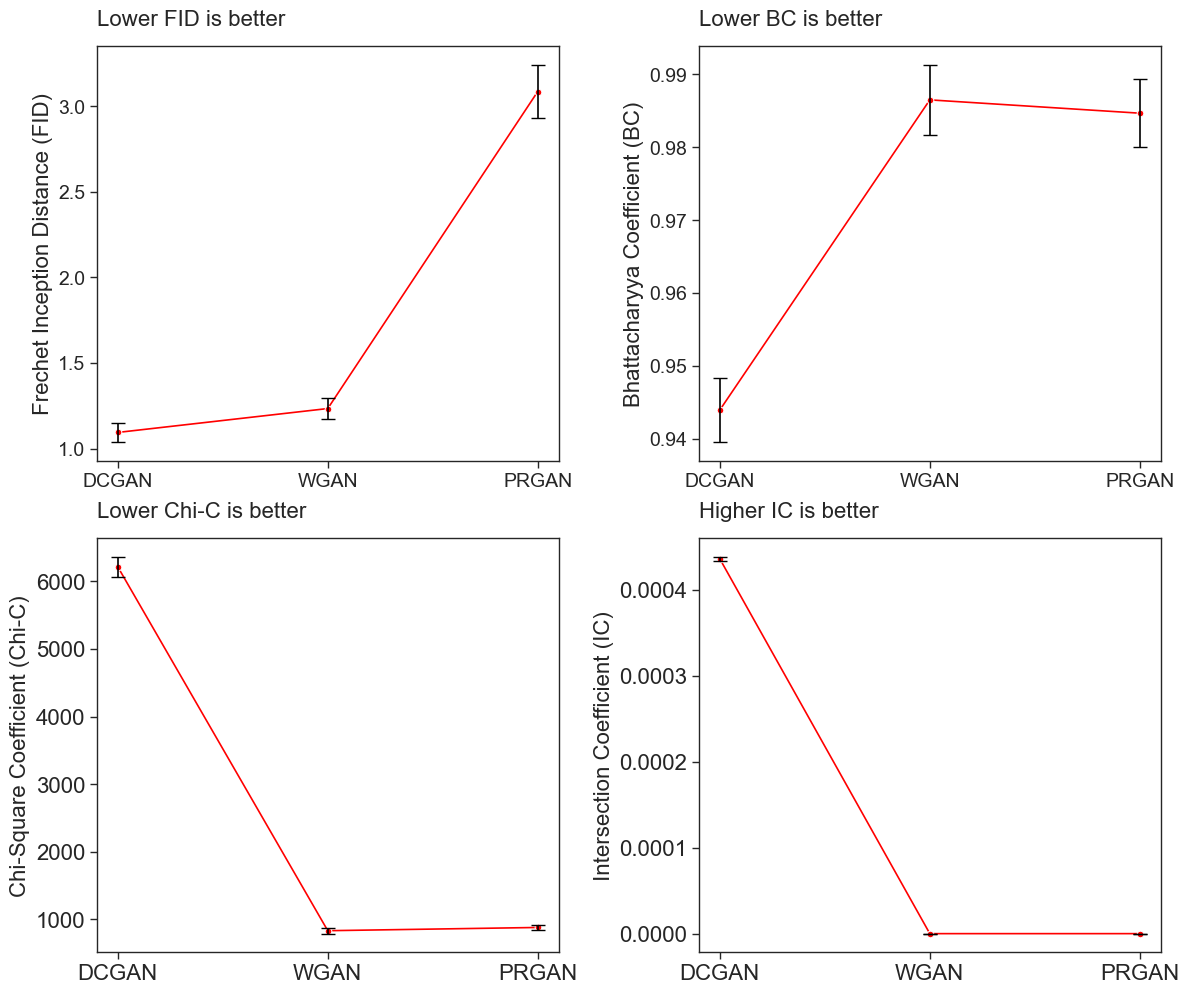

<Figure size 640x480 with 0 Axes>

In [47]:
# Data for FID comparison
model_names = ['DCGAN', 'WGAN', 'PRGAN']
fid_means = [dcgan_fid/1000, wgan_fid/1000, prgan_fid/1000]
fid_errors = [dcgan_fid_error/1000, wgan_fid_error/1000, prgan_fid_error/1000]
print(fid_means)

bc_means = [dcgan_bc, wgan_bc, prgan_bc]
bc_errors = [dcgan_bc_error, wgan_bc_error, prgan_bc_error]
print(bc_means)

cs_means = [dcgan_cs, wgan_cs, prgan_cs]
cs_errors = [dcgan_cs_error, wgan_cs_error, prgan_cs_error]
print(cs_means)

corr_means = [dcgan_corr, wgan_corr, prgan_corr]
corr_errors = [dcgan_corr_error, wgan_bc_error, prgan_corr_error]
print(corr_means)

inter_means = [dcgan_inter, wgan_inter, prgan_inter]
inter_errors = [dcgan_inter_error/1000, wgan_inter_error/1000, prgan_inter_error/1000]
print(inter_means)

# Create a figure with five subplots
fig, ((ax1, ax2), (ax3, ax5)) = plt.subplots(2, 2, figsize=(12, 10))

# Set larger font size
font_size = 16

# Plotting the FID comparison using a line chart with error bars
sns.lineplot(x=model_names, y=fid_means, marker='o', color='red', ax=ax1)
ax1.errorbar(x=model_names, y=fid_means, yerr=fid_errors, fmt='none', color='black', capsize=5)
ax1.set_ylabel('Frechet Inception Distance (FID)', fontsize=font_size)
ax1.text(0, 1.05, 'Lower FID is better', transform=ax1.transAxes, fontsize=font_size)
ax1.tick_params(axis='both', which='major', labelsize=font_size - 2)

# Plotting the BC comparison using a line chart with error bars
sns.lineplot(x=model_names, y=bc_means, marker='o', color='red', ax=ax2)
ax2.errorbar(x=model_names, y=bc_means, yerr=bc_errors, fmt='none', color='black', capsize=5)
ax2.set_ylabel('Bhattacharyya Coefficient (BC)', fontsize=font_size)
ax2.text(0, 1.05, 'Lower BC is better', transform=ax2.transAxes, fontsize=font_size)
ax2.tick_params(axis='both', which='major', labelsize=font_size - 2)

# Plotting the Chi-Square comparison using a line chart with error bars
sns.lineplot(x=model_names, y=cs_means, marker='o', color='red', ax=ax3)
ax3.errorbar(x=model_names, y=cs_means, yerr=cs_errors, fmt='none', color='black', capsize=5)
ax3.set_ylabel('Chi-Square Coefficient (Chi-C)', fontsize=font_size)
ax3.text(0, 1.05, 'Lower Chi-C is better', transform=ax3.transAxes, fontsize=font_size)
ax3.tick_params(axis='both', which='major', labelsize=font_size)

# Plotting the Intersection comparison using a line chart with error bars
sns.lineplot(x=model_names, y=inter_means, marker='o', color='red', ax=ax5)
ax5.errorbar(x=model_names, y=inter_means, yerr=inter_errors, fmt='none', color='black', capsize=5)
ax5.set_ylabel('Intersection Coefficient (IC)', fontsize=font_size)
ax5.text(0, 1.05, 'Higher IC is better', transform=ax5.transAxes, fontsize=font_size)
ax5.tick_params(axis='both', which='major', labelsize=font_size)

plt.tight_layout()
plt.savefig("results.pdf", format="pdf")
plt.show()


# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# CELL TO PERFORM DE-SPECLINKG ON BOTH DATASETS (REAL AND SYNTHETIC)

In [ ]:
# CELL TO PERFORM FEATURE ENGINEERING (Minimum, Maximum, Mean, SD, Kurtosis, Skew)

In [ ]:
# CELL TO PERFORM THE IMAGE CLASSIFICATION USING XGBoost AND LightGBM